# Creating annomaly plots with interannual variability between months for seasonal changes in phytoplankton biomass! 
### INCLUDING  ice fraction

In [3]:
import warnings
warnings.simplefilter("ignore") # Silence warnings
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import numpy as np
from matplotlib.pyplot import figure

import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import cartopy
import cartopy.crs as ccrs
import pylab 
from copy import deepcopy
import pandas as pd
import matplotlib
import matplotlib.colors as colors
from cartopy.util import add_cyclic_point
plt.rcParams['mathtext.default']='regular'
from collections import OrderedDict
import cmocean
import matplotlib.cm as cm
import matplotlib as mpl, and 
import seaborn as sns
from matplotlib.gridspec import GridSpec
import matplotlib
# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import os

%matplotlib inline
from glob import glob
import dask
import esmlab
import pop_tools 
from statistics import mean

In [4]:
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        if clip is None:
            clip = self.clip

        result, is_scalar = self.process_value(value)

        self.autoscale_None(result)
        vmin, vmax, midpoint = self.vmin, self.vmax, self.midpoint

        if not (vmin < midpoint < vmax):
            raise ValueError("midpoint must be between maxvalue and minvalue.")
        elif vmin == vmax:
            result.fill(0) # Or should it be all masked? Or 0.5?
        elif vmin > vmax:
            raise ValueError("maxvalue must be bigger than minvalue")
        else:
            vmin = float(vmin)
            vmax = float(vmax)
            if clip:
                mask = np.ma.getmask(result)
                result = np.ma.array(np.clip(result.filled(vmax), vmin, vmax),
                                  mask=mask)

            # ma division is very slow; we can take a shortcut
            resdat = result.data

            #First scale to -1 to 1 range, than to from 0 to 1.
            resdat -= midpoint
            resdat[resdat>0] /= abs(vmax - midpoint)
            resdat[resdat<0] /= abs(vmin - midpoint)

            resdat /= 2.
            resdat += 0.5
            result = np.ma.array(resdat, mask=result.mask, copy=False)

        if is_scalar:
            result = result[0]
        return result

In [5]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [6]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

## Seasonality and interannual variability in SPECTRA

In [7]:
case = 'g.e21.G1850ECOIAF.t62_g17.marbl0_33.GNG595'
path = f'/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/{case}/ocn/hist'

In [8]:
variables = [f'{var}' for var in ['diat1C','diat2C','diat3C', 'ppC', 'diazC', 'mp1C','mp2C','mp3C','mp4C','ECOSYS_IFRAC','TEMP','NO3']]
coords = {'x':'TLONG','y':'TLAT'}
keep_vars = variables + list(coords.values())+['dz','KMT','time']

In [9]:
%%time

ds_summer_avg = xr.Dataset()
ds_spring_avg = xr.Dataset()
ds_fall_avg = xr.Dataset()
ds_winter_avg =xr.Dataset()

for year in np.arange(63,125,1):
    yr4="0{:02d}".format(year).zfill(4)
    print(year)
    
    ds_summer = xr.Dataset()
    ds_spring = xr.Dataset()
    ds_winter = xr.Dataset()
    ds_fall = xr.Dataset()

    file = sorted(glob(f'{path}/{case}.pop.h.{yr4}-*.nc'))
    
    winter_indexes = [0,1,-1]
    winter_files = [file[ind] for ind in winter_indexes]
    dsv_winter=xr.open_mfdataset(winter_files, decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
        
    dsv_summer=xr.open_mfdataset(file[5:8], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_spring=xr.open_mfdataset(file[2:5], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    dsv_fall=xr.open_mfdataset(file[8:11], decode_times=True,drop_variables=["transport_components", "transport_regions"], 
                            parallel=True, compat="override", combine='nested', concat_dim="time",data_vars="minimal",coords='minimal' )
    
    for vv in variables: 
        ds_summer = xr.merge((ds_summer, dsv_summer[vv]))
        ds_spring = xr.merge((ds_spring, dsv_spring[vv]))
        ds_winter = xr.merge((ds_winter, dsv_winter[vv]))
        ds_fall = xr.merge((ds_fall, dsv_fall[vv]))
        

    ds_summer = ds_summer.drop([v for v in ds_summer.variables if v not in keep_vars]).squeeze()
    ds_summer = ds_summer.mean(dim='time')
    ds_summer_avg = xr.concat([ds_summer_avg, ds_summer],dim='year')
    
    ds_spring = ds_spring.drop([v for v in ds_spring.variables if v not in keep_vars]).squeeze()
    ds_spring = ds_spring.mean(dim='time')
    ds_spring_avg = xr.concat([ds_spring_avg, ds_spring],dim='year')
    
    ds_winter = ds_winter.drop([v for v in ds_winter.variables if v not in keep_vars]).squeeze()
    ds_winter = ds_winter.mean(dim='time')
    ds_winter_avg = xr.concat([ds_winter_avg, ds_winter],dim='year')
    
    ds_fall = ds_fall.drop([v for v in ds_fall.variables if v not in keep_vars]).squeeze()
    ds_fall = ds_fall.mean(dim='time')
    ds_fall_avg = xr.concat([ds_fall_avg, ds_fall],dim='year')

63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
CPU times: user 13min 16s, sys: 6min 5s, total: 19min 21s
Wall time: 20min 59s


In [10]:
%%time
phytoC_summer = np.stack([ds_summer_avg.ppC, ds_summer_avg.mp1C, ds_summer_avg.diazC, 
                   ds_summer_avg.mp2C, ds_summer_avg.diat1C, ds_summer_avg.diat2C, 
                   ds_summer_avg.mp3C, ds_summer_avg.diat3C, ds_summer_avg.mp4C])

CPU times: user 54.1 s, sys: 3min 1s, total: 3min 55s
Wall time: 8min 41s


In [11]:
%%time
phytoC_spring = np.stack([ds_spring_avg.ppC, ds_spring_avg.mp1C, ds_spring_avg.diazC, 
                   ds_spring_avg.mp2C, ds_spring_avg.diat1C, ds_spring_avg.diat2C, 
                   ds_spring_avg.mp3C, ds_spring_avg.diat3C, ds_spring_avg.mp4C])

CPU times: user 56.9 s, sys: 3min 4s, total: 4min 1s
Wall time: 9min 31s


In [12]:
%%time
phytoC_winter = np.stack([ds_winter_avg.ppC, ds_winter_avg.mp1C, ds_winter_avg.diazC, 
                   ds_winter_avg.mp2C, ds_winter_avg.diat1C, ds_winter_avg.diat2C, 
                   ds_winter_avg.mp3C, ds_winter_avg.diat3C, ds_winter_avg.mp4C])

CPU times: user 56 s, sys: 3min 5s, total: 4min 1s
Wall time: 9min 33s


In [13]:
%%time
phytoC_fall = np.stack([ds_fall_avg.ppC, ds_fall_avg.mp1C, ds_fall_avg.diazC, 
                   ds_fall_avg.mp2C, ds_fall_avg.diat1C, ds_fall_avg.diat2C, 
                   ds_fall_avg.mp3C, ds_fall_avg.diat3C, ds_fall_avg.mp4C])

CPU times: user 55.8 s, sys: 3min 3s, total: 3min 58s
Wall time: 9min 28s


### Biomass

In [14]:
phytoC_fall.shape

(9, 62, 15, 384, 320)

In [15]:
phytoC_summer.shape

(9, 62, 15, 384, 320)

In [16]:
%%time
phytoC_summer_bm = np.nansum(phytoC_summer, axis=(0,2)) * 10/150 #integrate over depth #mmol m-3
phytoC_summer_bm = phytoC_summer_bm * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

phytoC_spring_bm = np.nansum(phytoC_spring, axis=(0,2)) * 10/150 #integrate over depth #mmol m-3
phytoC_spring_bm = phytoC_spring_bm * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

phytoC_fall_bm = np.nansum(phytoC_fall, axis=(0,2)) * 10/150 #integrate over depth #mmol m-3
phytoC_fall_bm = phytoC_fall_bm * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

phytoC_winter_bm = np.nansum(phytoC_winter, axis=(0,2)) * 10/150 #integrate over depth #mmol m-3
phytoC_winter_bm = phytoC_winter_bm * 12.011 *1000 # ug C m-3 --> ugC m^{-3}

CPU times: user 16.4 s, sys: 59.7 s, total: 1min 16s
Wall time: 5min 39s


In [17]:
phytoC_summer_bm.shape

(62, 384, 320)

In [18]:
phytoC_summer_bm[phytoC_summer_bm<0] ==np.nan
phytoC_spring_bm[phytoC_spring_bm<0] ==np.nan
phytoC_fall_bm[phytoC_fall_bm<0] ==np.nan
phytoC_winter_bm[phytoC_winter_bm<0] ==np.nan

array([], dtype=bool)

## Bring in Grid information

In [19]:
## Bring in Grid information -- /glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim/
grid_inds = sorted(glob('/glade/u/home/gabyn/scratch/SPECTRA/GNG595_2ndcycle_1990-2009_clim/regrid/regrid_SPECTRA_TAREA.*.nc', recursive=True))
ds= xr.open_mfdataset(grid_inds,concat_dim='time', combine='nested') # Full 62 years of second cycle

In [20]:
ds.TAREA[0,:,:]

<xarray.DataArray 'TAREA' (lat: 180, lon: 360)>
dask.array<getitem, shape=(180, 360), dtype=float64, chunksize=(180, 360), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 -180.0 -179.0 -178.0 -177.0 ... 177.0 178.0 179.0
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
Attributes:
    long_name:  area of T cells
    units:      centimeter^2

## High vs low temperature

In [21]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_TEMP.*.nc', recursive=True))
ds_01= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [22]:
%%time
temp_ds_inter = np.empty([62,12,180,360])
temp_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    temp_ds_inter[i,:,:,:] = ds_01.TEMP[x[i]:x[i]+12,0,:,:]

CPU times: user 10.8 s, sys: 13.2 s, total: 24 s
Wall time: 35.4 s


In [23]:
inter = xr.DataArray(temp_ds_inter, coords={'year':ds_fall_avg.year, 'time':ds.time, 'lat':ds.lat, 'lon':ds.lon},
                      dims=['year', 'time', 'lat', 'lon'])
inter = inter.to_dataset(name='temp_ds_inter')
temp_arctic = esmlab.statistics.weighted_sum(inter.temp_ds_inter[:,:,149:180,:], weights=ds.TAREA[0,149:180,:], dim=['lat', 'lon'])

In [24]:
#temp_arctic = np.nanmean(temp_ds_inter[:,:,149:180,:], axis=(2,3))
temp_arctic_anom = temp_arctic-np.nanmean(temp_arctic,axis=0)
err_ao = np.nanstd(temp_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
cold_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) < -(err_ao/2))
warm_years_arctic = np.where(np.nanmean(temp_arctic_anom,axis=1) > (err_ao/2))

In [25]:
warm_years_arctic

(array([ 0,  2,  5,  6, 50, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61]),)

In [26]:
cold_years_summer = phytoC_summer_bm[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_summer = phytoC_summer_bm[warm_years_arctic,:,:] # 1/2 standard deviation 

cold_years_spring = phytoC_spring_bm[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_spring = phytoC_spring_bm[warm_years_arctic,:,:] # 1/2 standard deviation 

cold_years_fall = phytoC_fall_bm[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_fall = phytoC_fall_bm[warm_years_arctic,:,:] # 1/2 standard deviation 

cold_years_winter = phytoC_winter_bm[cold_years_arctic,:,:] # 1/2 standard deviation 
warm_years_winter = phytoC_winter_bm[warm_years_arctic,:,:] # 1/2 standard deviation 

## High vs low Ice Fraction

In [27]:
temp_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_ECOSYS_IFRAC*.nc', recursive=True))
ds_02= xr.open_mfdataset(temp_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [28]:
ECOSYS_IFRAC_ds_inter = np.empty([62,12,180,360])
ECOSYS_IFRAC_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    ECOSYS_IFRAC_ds_inter[i,:,:,:] = ds_02.ECOSYS_IFRAC[x[i]:x[i]+12,:,:]

In [29]:
inter = xr.DataArray(ECOSYS_IFRAC_ds_inter, coords={'year':ds_fall_avg.year, 'time':ds.time, 'lat':ds.lat, 'lon':ds.lon},
                      dims=['year', 'time', 'lat', 'lon'])
inter = inter.to_dataset(name='ECOSYS_IFRAC_ds_inter')
ice_arctic = esmlab.statistics.weighted_sum(inter.ECOSYS_IFRAC_ds_inter[:,:,149:180,:], weights=ds.TAREA[0,149:180,:], dim=['lat', 'lon'])

In [30]:
#ice_arctic = np.nanmean(ECOSYS_IFRAC_ds_inter[:,:,149:180,:], axis=(2,3))
ice_arctic_anom = ice_arctic-np.nanmean(ice_arctic,axis=0)
err_ao = np.nanstd(ice_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) < -(err_ao/2))
high_ice_years_arctic = np.where(np.nanmean(ice_arctic_anom,axis=1) > (err_ao/2))

In [31]:
low_ice_years_summer = phytoC_summer_bm[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_summer = phytoC_summer_bm[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_spring = phytoC_spring_bm[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_spring = phytoC_spring_bm[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_fall = phytoC_fall_bm[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_fall = phytoC_fall_bm[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_winter = phytoC_winter_bm[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_winter = phytoC_winter_bm[high_ice_years_arctic,:,:] # 1/2 standard deviation 

## High vs low NO$_3$

In [32]:
NO3_inds = sorted(glob('/glade/scratch/gabyn/SPECTRA/GNG595_monthly_yearly_1948_2009/regrid/regrid_SPECTRA_NO3*.nc', recursive=True))
ds_03= xr.open_mfdataset(NO3_inds[1::],concat_dim='time', combine='nested') # Full 62 years of second cycle

In [33]:
NO3_ds_inter = np.empty([62,12,180,360])
NO3_ds_inter[:] = np.nan
x = np.array(range(0,744,12)) ## this loops from 0 to 2016, and selects every 12th number. 
for i in range(62):
    NO3_ds_inter[i,:,:,:] = ds_03.NO3[x[i]:x[i]+12,0,:,:]

In [34]:
inter = xr.DataArray(NO3_ds_inter, coords={'year':ds_fall_avg.year, 'time':ds.time, 'lat':ds.lat, 'lon':ds.lon},
                      dims=['year', 'time', 'lat', 'lon'])
inter = inter.to_dataset(name='NO3_ds_inter')
no3_arctic = esmlab.statistics.weighted_sum(inter.NO3_ds_inter[:,:,149:180,:], weights=ds.TAREA[0,149:180,:], dim=['lat', 'lon'])

In [35]:
#no3_arctic = np.nanmean(NO3_ds_inter[:,:,149:180,:], axis=(2,3))
no3_arctic_anom = no3_arctic-np.nanmean(no3_arctic,axis=0)
err_ao = np.nanstd(no3_arctic_anom,axis=(0,1))

# Selecting the warm and cold years as less or more than 1/3 of standard deviation 
low_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) < -(err_ao/2))
high_no3_years_arctic = np.where(np.nanmean(no3_arctic_anom,axis=1) > (err_ao/2))

In [36]:
low_no3_years_summer = phytoC_summer_bm[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_summer = phytoC_summer_bm[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_spring = phytoC_spring_bm[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_spring = phytoC_spring_bm[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_fall = phytoC_fall_bm[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_fall = phytoC_fall_bm[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_winter = phytoC_winter_bm[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_winter = phytoC_winter_bm[high_no3_years_arctic,:,:] # 1/2 standard deviation 

## Now select the ice under all of these differnt things during the different seasons?

In [37]:
ice_frac_summer = np.array(ds_summer_avg.ECOSYS_IFRAC)
ice_frac_winter = np.array(ds_winter_avg.ECOSYS_IFRAC)
ice_frac_fall = np.array(ds_fall_avg.ECOSYS_IFRAC)
ice_frac_spring = np.array(ds_spring_avg.ECOSYS_IFRAC)

In [38]:
## NO3
low_no3_years_summer_ice = ice_frac_summer[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_summer_ice = ice_frac_summer[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_spring_ice = ice_frac_spring[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_spring_ice= ice_frac_spring[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_fall_ice = ice_frac_fall[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_fall_ice = ice_frac_fall[high_no3_years_arctic,:,:] # 1/2 standard deviation 

low_no3_years_winter_ice = ice_frac_winter[low_no3_years_arctic,:,:] # 1/2 standard deviation 
high_no3_years_winter_ice = ice_frac_winter[high_no3_years_arctic,:,:] # 1/2 standard deviation 

## ice
low_ice_years_summer_ice = ice_frac_summer[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_summer_ice = ice_frac_summer[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_spring_ice = ice_frac_spring[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_spring_ice= ice_frac_spring[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_fall_ice = ice_frac_fall[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_fall_ice = ice_frac_fall[high_ice_years_arctic,:,:] # 1/2 standard deviation 

low_ice_years_winter_ice = ice_frac_winter[low_ice_years_arctic,:,:] # 1/2 standard deviation 
high_ice_years_winter_ice = ice_frac_winter[high_ice_years_arctic,:,:] # 1/2 standard deviation 

## temperature
low_temp_years_summer_ice = ice_frac_summer[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_summer_ice = ice_frac_summer[warm_years_arctic,:,:] # 1/2 standard deviation 

low_temp_years_spring_ice = ice_frac_spring[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_spring_ice= ice_frac_spring[warm_years_arctic,:,:] # 1/2 standard deviation 

low_temp_years_fall_ice = ice_frac_fall[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_fall_ice = ice_frac_fall[warm_years_arctic,:,:] # 1/2 standard deviation 

low_temp_years_winter_ice = ice_frac_winter[cold_years_arctic,:,:] # 1/2 standard deviation 
high_temp_years_winter_ice = ice_frac_winter[warm_years_arctic,:,:] # 1/2 standard deviation 

## Temperature differences 

In [39]:
temp_summer = np.array(ds_summer_avg.TEMP)
temp_winter = np.array(ds_winter_avg.TEMP)
temp_fall = np.array(ds_fall_avg.TEMP)
temp_spring = np.array(ds_spring_avg.TEMP)

In [40]:
%%time
## temperature
low_high_summer_temp = np.nanmean(temp_summer[cold_years_arctic,:,:],axis=(0,1,2))-np.nanmean(temp_summer[warm_years_arctic,:,:],axis=(0,1,2))

low_high_spring_temp = np.nanmean(temp_spring[cold_years_arctic,:,:],axis=(0,1,2)) -np.nanmean(temp_spring[warm_years_arctic,:,:],axis=(0,1,2)) 

low_high_fall_temp = np.nanmean(temp_fall[cold_years_arctic,:,:],axis=(0,1,2)) -np.nanmean(temp_fall[warm_years_arctic,:,:],axis=(0,1,2))

low_high_winter_temp = np.nanmean(temp_winter[cold_years_arctic,:,:],axis=(0,1,2)) - np.nanmean(temp_winter[warm_years_arctic,:,:],axis=(0,1,2))

CPU times: user 4.75 s, sys: 7.18 s, total: 11.9 s
Wall time: 30.2 s


## No3 differences 

In [41]:
%%time
no3_summer = np.array(ds_summer_avg.NO3)
no3_winter = np.array(ds_winter_avg.NO3)
no3_fall = np.array(ds_fall_avg.NO3)
no3_spring = np.array(ds_spring_avg.NO3)

CPU times: user 1min 18s, sys: 6min 40s, total: 7min 58s
Wall time: 11min 38s


In [42]:
## NO3
high_low_summer_no3 = np.nanmean(no3_summer[high_no3_years_arctic,:,:],axis=(0,1,2))-np.nanmean(no3_summer[low_no3_years_arctic,:,:],axis=(0,1,2)) 

high_low_spring_no3 = np.nanmean(no3_spring[high_no3_years_arctic,:,:],axis=(0,1,2))-np.nanmean(no3_spring[low_no3_years_arctic,:,:],axis=(0,1,2)) 

high_low_fall_no3 = np.nanmean(no3_fall[high_no3_years_arctic,:,:],axis=(0,1,2))-np.nanmean(no3_fall[low_no3_years_arctic,:,:],axis=(0,1,2))

high_low_winter_no3 = np.nanmean(no3_winter[high_no3_years_arctic,:,:],axis=(0,1,2))-np.nanmean(no3_winter[low_no3_years_arctic,:,:],axis=(0,1,2)) 

## Plot the NO3 differences between the high and the low nutrient years, and the same with temperature and ice... 

In [43]:
cold_years_temp = np.nanmean(temp_ds_inter[cold_years_arctic,:,:,:],axis=(0,1,2))
warm_years_temp = np.nanmean(temp_ds_inter[warm_years_arctic,:,:,:],axis=(0,1,2)) 

high_NO3_years_NO3 =np.nanmean(NO3_ds_inter[high_no3_years_arctic,:,:,:],axis=(0,1,2))
low_NO3_years_NO3 = np.nanmean(NO3_ds_inter[low_no3_years_arctic,:,:,:],axis=(0,1,2))

high_ice_years_ice =np.nanmean(ECOSYS_IFRAC_ds_inter[high_ice_years_arctic,:,:,:],axis=(0,1,2))
low_ice_years_ice = np.nanmean(ECOSYS_IFRAC_ds_inter[low_ice_years_arctic,:,:,:],axis=(0,1,2))

Text(0.5, 1.0, '')

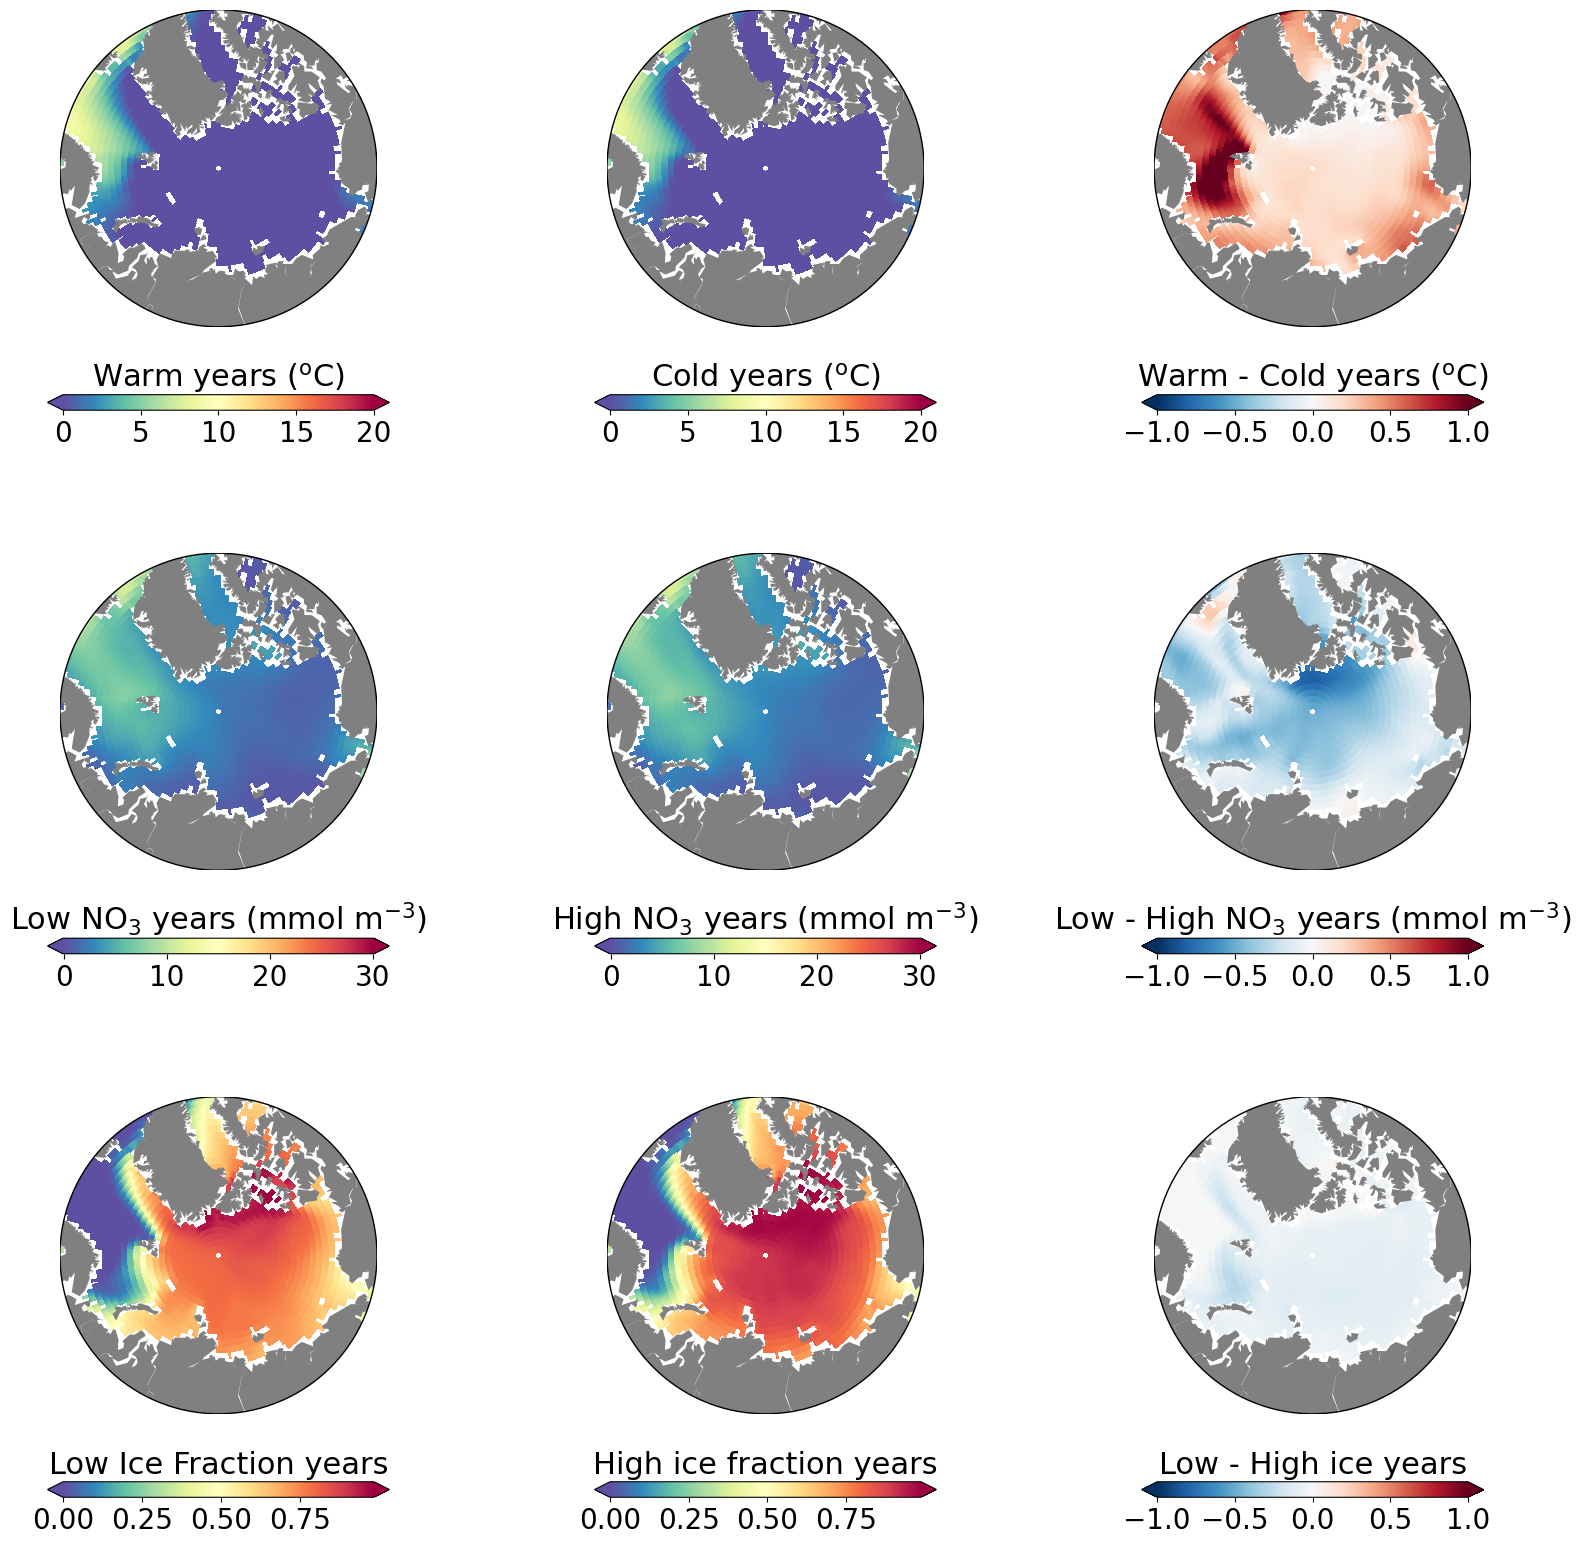

In [44]:
fig = plt.figure(figsize=(20, 20))
lat = ds.lat

# Temperature 
ax = fig.add_subplot(3, 3, 2)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cold, lon = add_cyclic_point(cold_years_temp, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,cold,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 1)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
warm, lon = add_cyclic_point(warm_years_temp, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,warm,cmap='Spectral_r',vmin=0,vmax=20)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 3)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,warm-cold,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Warm - Cold years ($^oC$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

# NO3 
ax = fig.add_subplot(3, 3, 4)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
low, lon = add_cyclic_point(low_NO3_years_NO3, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,low,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Low NO$_3$ years (mmol $m^{-3}$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 5)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
high, lon = add_cyclic_point(high_NO3_years_NO3, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,high,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('High NO$_3$ years (mmol $m^{-3}$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 6)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,low-high,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Low - High NO$_3$ years (mmol $m^{-3}$)', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


# Ice 
ax = fig.add_subplot(3, 3, 7)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
low, lon = add_cyclic_point(low_ice_years_ice, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,low,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Low Ice Fraction years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)

ax = fig.add_subplot(3, 3, 8)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
high, lon = add_cyclic_point(high_ice_years_ice, coord=ds.lon, axis=1)
x, y = m(*np.meshgrid(lon,ds_01.lat))
cf = m.pcolor(x,y,high,cmap='Spectral_r')
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('High ice fraction years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


ax = fig.add_subplot(3, 3, 9)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
cf = m.pcolor(x,y,low-high,cmap='RdBu_r', vmin = -1, vmax = 1)
cb = plt.colorbar(cf, shrink=0.75, orientation='horizontal',extend = 'both')
cb.ax.set_title('Low - High ice years', fontsize = 22)
cb.ax.tick_params(labelsize=20)
ax.set_title('', fontsize =20)


## Plot them all together! 

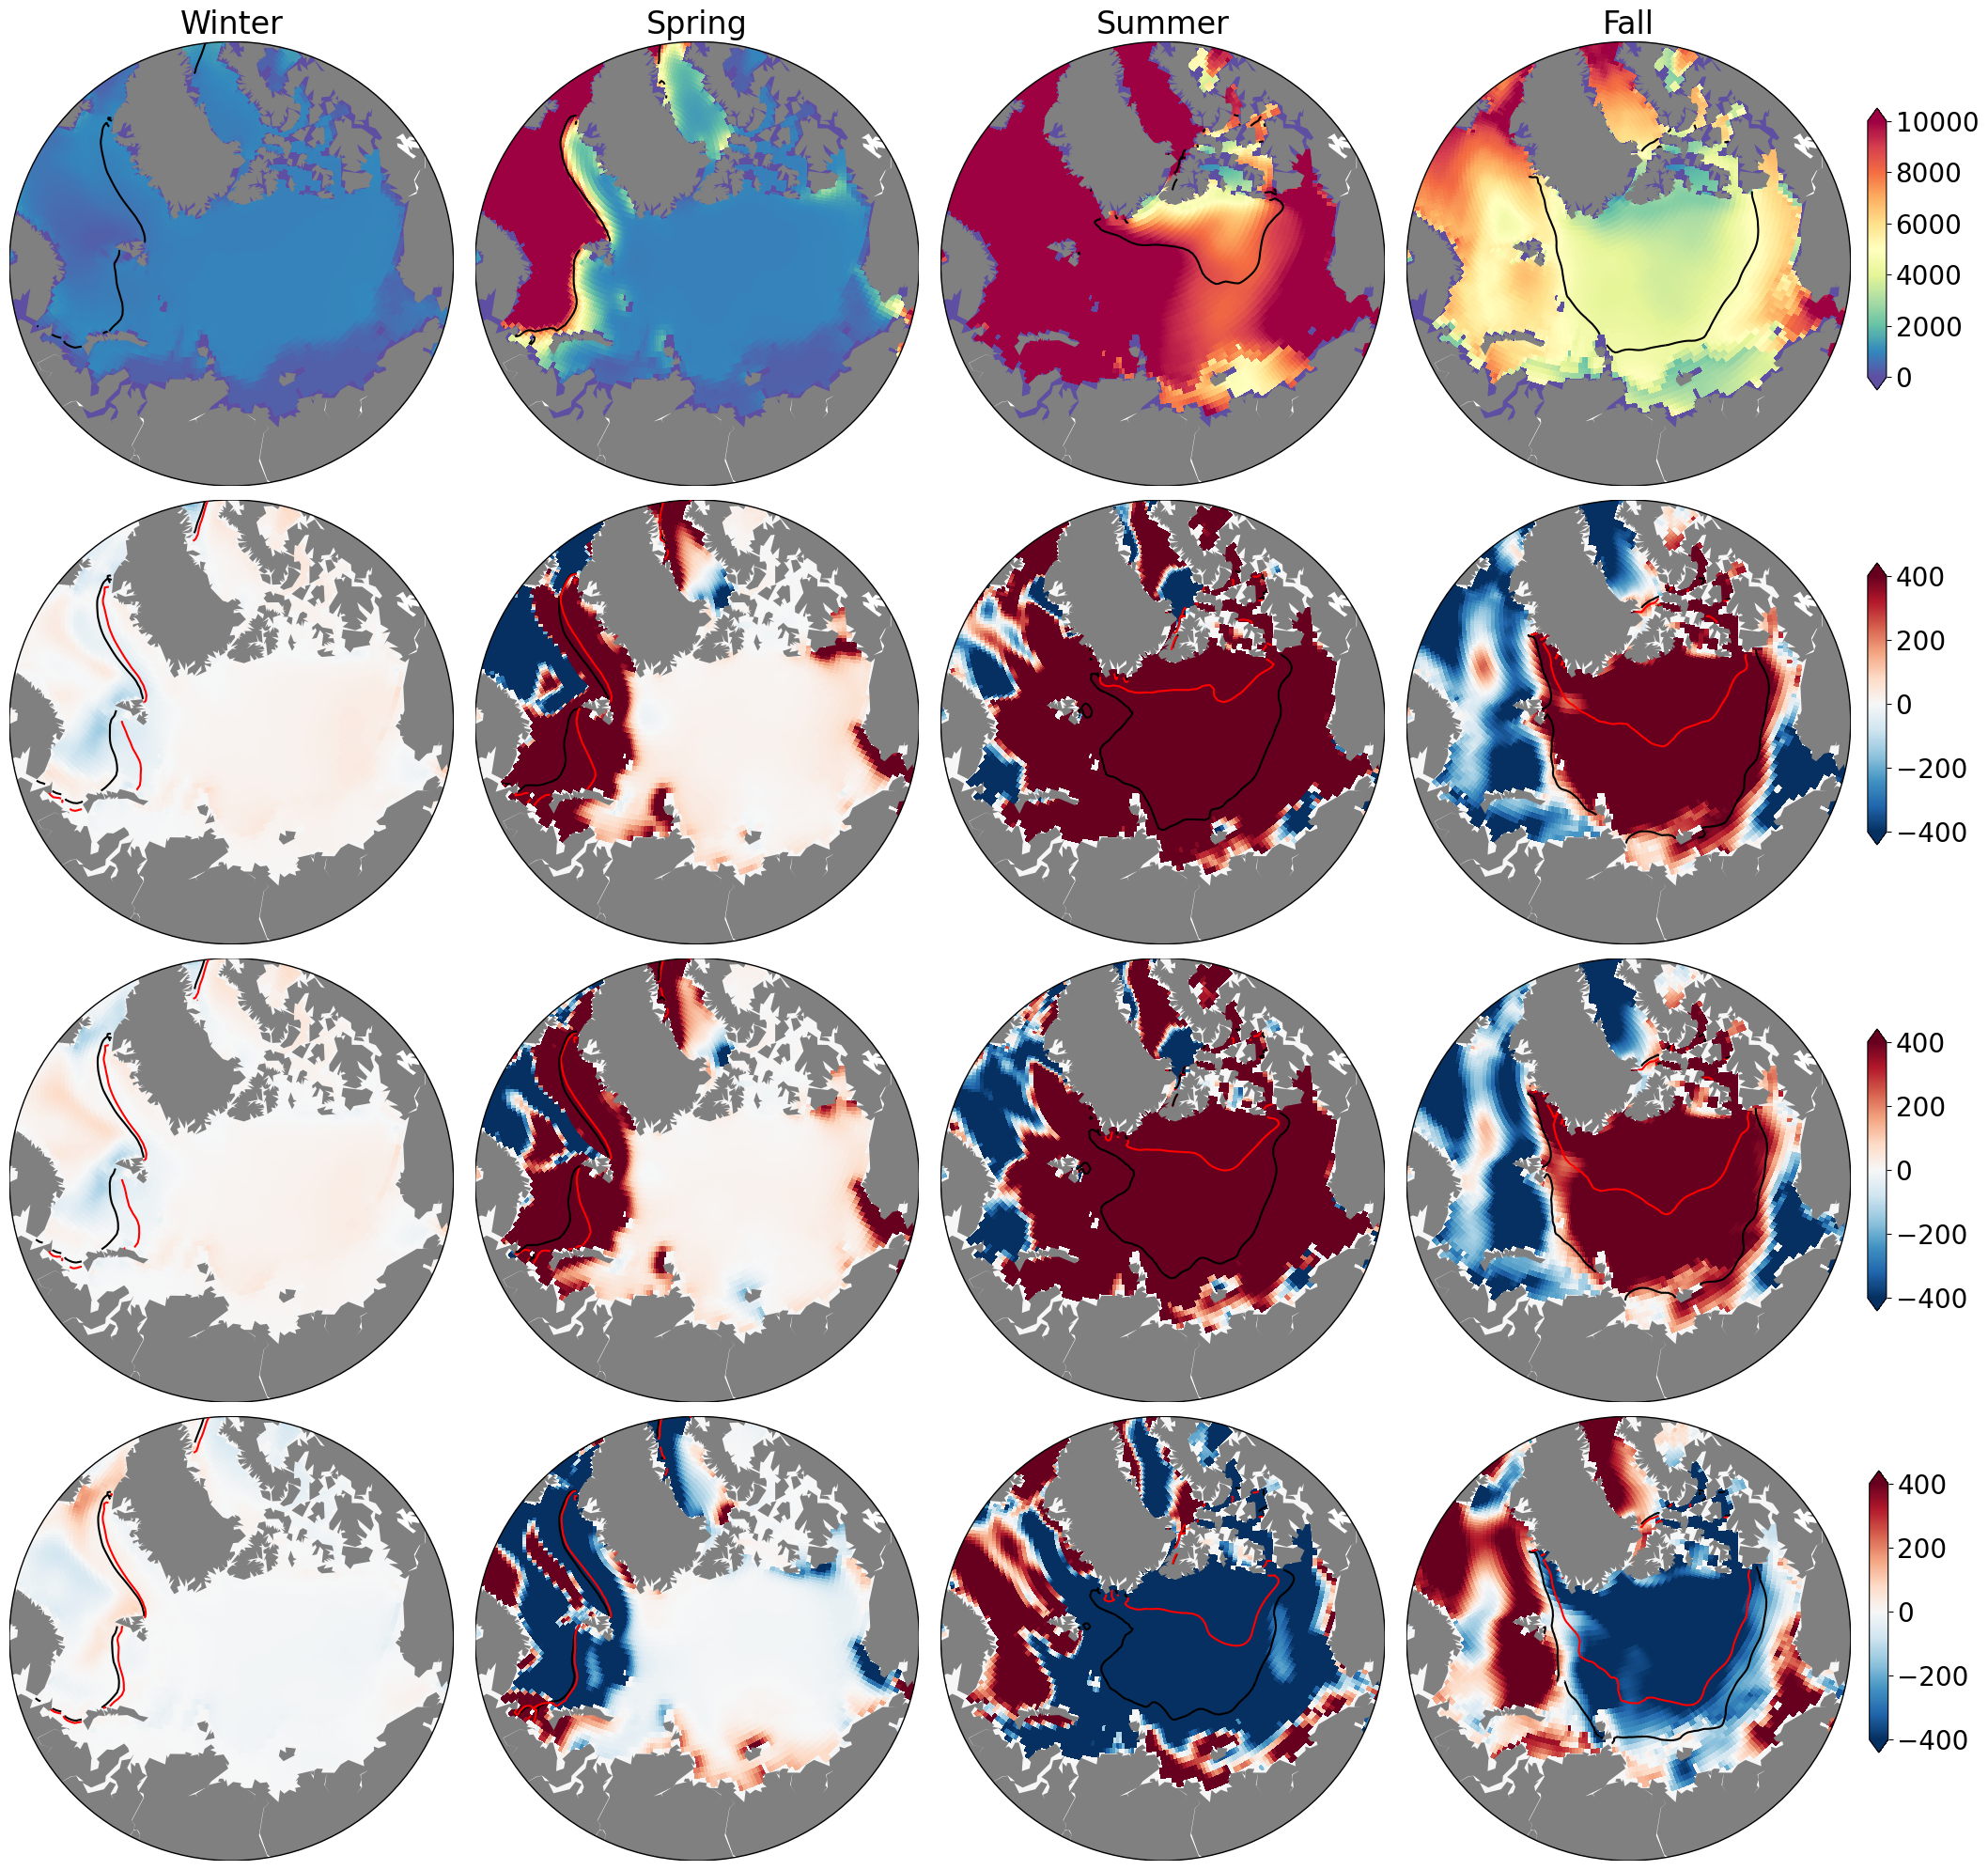

In [45]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

# Winter 
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_winter_bm,axis=0))
tlon, tlat, winter_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_winter_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
#ax = axes_1[2]
lon, lat, spring = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_spring_bm, axis=0))
tlon, tlat, spring_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_spring_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
#ax = axes_1[3]
lon, lat, summer = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_summer_bm, axis=0))
tlon, tlat, summer_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_summer_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
#ax = axes_1[4]
lon, lat, fall = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_fall_bm, axis=0))
tlon, tlat, fall_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_fall_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.79, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel('Phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 
vminn = -400
vmaxx = 400
# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 9)
#ax = axes_2[0]
winter_temp_diff = ((np.nanmean(warm_years_winter, axis=(0,1))-np.nanmean(cold_years_winter, axis=(0,1))))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_temp_diff)
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 10)
#ax = axes_2[1]
spring_temp_diff = ((np.nanmean(warm_years_spring, axis=(0,1))-np.nanmean(cold_years_spring, axis=(0,1))))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_temp_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 11)
#ax = axes_2[2]
summer_temp_diff = ((np.nanmean(warm_years_summer, axis=(0,1))-np.nanmean(cold_years_summer, axis=(0,1))))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_temp_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 12)
#ax = axes_2[3]
fall_temp_diff = ((np.nanmean(warm_years_fall, axis=(0,1))-np.nanmean(cold_years_fall, axis=(0,1))))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_temp_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 

cbar_ax = fig.add_axes([0.999, 0.3, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low temperature)', fontsize=20)
cb.ax.tick_params(labelsize=20)


## Ice Fraction
#axes_3 = subfig_3.subplots(nrows=1, ncols=4, sharey=True)
# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 5)
#ax = axes_3[0]
winter_ice_diff = ((np.nanmean(low_ice_years_winter, axis=(0,1))-np.nanmean(high_ice_years_winter, axis=(0,1))))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_ice_diff)
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 6)
#ax = axes_3[1]
spring_ice_diff = ((np.nanmean(low_ice_years_spring, axis=(0,1))-np.nanmean(high_ice_years_spring, axis=(0,1))))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_ice_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 7)
#ax = axes_3[2]
summer_ice_diff = ((np.nanmean(low_ice_years_summer, axis=(0,1))-np.nanmean(high_ice_years_summer, axis=(0,1))))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_ice_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 8)
#ax = axes_3[3]
fall_ice_diff = ((np.nanmean(low_ice_years_fall, axis=(0,1))-np.nanmean(high_ice_years_fall, axis=(0,1))))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_ice_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 

cbar_ax = fig.add_axes([0.999, 0.548, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (low-high ice)', fontsize=20)
cb.ax.tick_params(labelsize=20)

#NO3

#axes_4 = subfig_4.subplots(nrows=1, ncols=4, sharey=True)
# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
#ax = axes_4[0]
winter_no3_diff = ((np.nanmean(high_no3_years_winter, axis=(0,1))-np.nanmean(low_no3_years_winter, axis=(0,1))))
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
#ax = axes_4[1]
spring_no3_diff = ((np.nanmean(high_no3_years_spring, axis=(0,1))-np.nanmean(low_no3_years_spring, axis=(0,1))))
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_no3_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
#ax = axes_4[2]
summer_no3_diff = ((np.nanmean(high_no3_years_summer, axis=(0,1))-np.nanmean(low_no3_years_summer, axis=(0,1))))
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_no3_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 

# Fall, % difference of catch from high and low NO$_3$  years. 
#ax = fig.add_subplot(4, 4, 16)
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = ((np.nanmean(high_no3_years_fall, axis=(0,1))-np.nanmean(low_no3_years_fall, axis=(0,1))))
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_no3_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 


cbar_ax = fig.add_axes([0.9999, 0.065, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.set_ylabel(' Absolute difference (high - low NO$_3$)', fontsize=20)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_biomass_absolutediff_interannual_62yr_area_weighted.png',dpi=600, bbox_inches='tight')

## Scatter plot

In [ ]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Summer NO$_3$ Difference (high-low) (mmol/m$^3$)', fontsize = 15)
ax.set_ylabel(' NO$_3$ Difference (high-low) (mmol/m$^3$)', fontsize = 15)

ax.scatter(summer_no3_diff.flatten(),
           high_low_summer_no3.flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
line = mlines.Line2D([-2, 2], [-2, 2], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

ax.legend(loc='best', fontsize=16)


In [ ]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Summer temp Difference (low-high) (C)', fontsize = 15)
ax.set_ylabel(' temp Difference (low-high) (C)', fontsize = 15)

ax.scatter(summer_temp_diff.flatten(),
           low_high_summer_temp.flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
line = mlines.Line2D([-2, 2], [-2, 2], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

ax.legend(loc='best', fontsize=16)


In [ ]:
import matplotlib
import matplotlib.lines as mlines
import matplotlib.transforms as mtransforms
cmap1=matplotlib.cm.get_cmap('Spectral', 11)

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(1,1,1) 
ax.set_xlabel('Summer ice difference (high-low)', fontsize = 15)
ax.set_ylabel(' ice difference (high-low)', fontsize = 15)

ax.scatter(summer_ice_diff.flatten(),
           high_low_summer_ice.flatten(),
           color = cmap1(0), s = 50,label='Central Arctic')
line = mlines.Line2D([-2, 2], [-2, 2], color='black')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)

ax.legend(loc='best', fontsize=16)


In [ ]:
summer_no3_diff.shape

In [ ]:
high_low_summer_no3.shape

In [ ]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

# Figure and Subfigure information 
#fig = plt.figure(constrained_layout=True)
#(subfig_1, subfig_2,subfig_3, subfig_4) = fig.subfigures(nrows=4, ncols=1)

# SubFigure 1... 

#axes_1 = subfig_1.subplots(nrows=1, ncols=4, sharey=True)

# Winter 
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_winter_bm,axis=0))
tlon, tlat, winter_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_winter_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
#ax = axes_1[2]
lon, lat, spring = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_spring_bm, axis=0))
tlon, tlat, spring_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_spring_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
#ax = axes_1[3]
lon, lat, summer = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_summer_bm, axis=0))
tlon, tlat, summer_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_summer_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
#ax = axes_1[4]
lon, lat, fall = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_fall_bm, axis=0))
tlon, tlat, fall_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_fall_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
#lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title('phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.15, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 
vminn=-30
vmaxx=30
# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
#ax = axes_2[0]
winter_temp_diff = ((np.nanmean(cold_years_winter, axis=(0,1))-np.nanmean(warm_years_winter, axis=(0,1)))/np.nanmean(warm_years_winter, axis=(0,1)))*100
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_temp_diff)
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
#ax = axes_2[1]
spring_temp_diff = ((np.nanmean(cold_years_spring, axis=(0,1))-np.nanmean(warm_years_spring, axis=(0,1)))/np.nanmean(warm_years_spring, axis=(0,1)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_temp_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
#ax = axes_2[2]
summer_temp_diff = ((np.nanmean(cold_years_summer, axis=(0,1))-np.nanmean(warm_years_summer, axis=(0,1)))/np.nanmean(warm_years_summer, axis=(0,1)))*100
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_temp_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
#ax = axes_2[3]
fall_temp_diff = ((np.nanmean(cold_years_fall, axis=(0,1))-np.nanmean(warm_years_fall, axis=(0,1)))/np.nanmean(warm_years_fall, axis=(0,1)))*100
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_temp_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

#cbar_ax = fig.add_axes([0.93, 0.55, 0.01, 0.1])
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.tick_params(labelsize=20)


## Ice Fraction
#axes_3 = subfig_3.subplots(nrows=1, ncols=4, sharey=True)
# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 9)
#ax = axes_3[0]
winter_ice_diff = ((np.nanmean(high_ice_years_winter, axis=(0,1))-np.nanmean(low_ice_years_winter, axis=(0,1)))/np.nanmean(low_ice_years_winter, axis=(0,1)))*100
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_ice_diff)
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 10)
#ax = axes_3[1]
spring_ice_diff = ((np.nanmean(high_ice_years_spring, axis=(0,1))-np.nanmean(low_ice_years_spring, axis=(0,1)))/np.nanmean(low_ice_years_spring, axis=(0,1)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_ice_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 11)
#ax = axes_3[2]
summer_ice_diff = ((np.nanmean(high_ice_years_summer, axis=(0,1))-np.nanmean(low_ice_years_summer, axis=(0,1)))/np.nanmean(low_ice_years_summer, axis=(0,1)))*100
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_ice_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 12)
#ax = axes_3[3]
fall_ice_diff = ((np.nanmean(high_ice_years_fall, axis=(0,1))-np.nanmean(low_ice_years_fall, axis=(0,1)))/np.nanmean(low_ice_years_fall, axis=(0,1)))*100
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_ice_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

#cbar_ax = fig.add_axes([0.93, 0.34, 0.01, 0.1])
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.tick_params(labelsize=20)

#NO3

#axes_4 = subfig_4.subplots(nrows=1, ncols=4, sharey=True)
# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
#ax = axes_4[0]
winter_no3_diff = ((np.nanmean(high_no3_years_winter, axis=(0,1))-np.nanmean(low_no3_years_winter, axis=(0,1)))/np.nanmean(low_no3_years_winter, axis=(0,1)))*100
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
#ax = axes_4[1]
spring_no3_diff = ((np.nanmean(high_no3_years_spring, axis=(0,1))-np.nanmean(low_no3_years_spring, axis=(0,1)))/np.nanmean(low_no3_years_spring, axis=(0,1)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_no3_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
#ax = axes_4[2]
summer_no3_diff = ((np.nanmean(high_no3_years_summer, axis=(0,1))-np.nanmean(low_no3_years_summer, axis=(0,1)))/np.nanmean(low_no3_years_summer, axis=(0,1)))*100
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_no3_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low NO$_3$  years. 
#ax = fig.add_subplot(4, 4, 16)
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = ((np.nanmean(high_no3_years_fall, axis=(0,1))-np.nanmean(low_no3_years_fall, axis=(0,1)))/np.nanmean(low_no3_years_fall, axis=(0,1)))*100
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_no3_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.tick_params(labelsize=20)


cbar_ax = fig.add_axes([0.9999, 0.75, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_biomass_quarterly_interannual_62yr_area_weighted.png',dpi=600, bbox_inches='tight')

In [ ]:
lev = np.arange(0, 1, 0.01)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.5)
fig = plt.figure(figsize=(20, 20))

# Figure and Subfigure information 
#fig = plt.figure(constrained_layout=True)
#(subfig_1, subfig_2,subfig_3, subfig_4) = fig.subfigures(nrows=4, ncols=1)

# SubFigure 1... 

#axes_1 = subfig_1.subplots(nrows=1, ncols=4, sharey=True)

# Winter 
ax = fig.add_subplot(4, 4, 1)
lon, lat, winter = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_winter_bm,axis=0))
tlon, tlat, winter_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_winter_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, winter, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, winter_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Winter', fontsize =24)

# Spring 
ax = fig.add_subplot(4, 4, 2)
#ax = axes_1[2]
lon, lat, spring = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_spring_bm, axis=0))
tlon, tlat, spring_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_spring_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, spring, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, spring_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Spring', fontsize =24)

# Summer 
ax = fig.add_subplot(4, 4, 3)
#ax = axes_1[3]
lon, lat, summer = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_summer_bm, axis=0))
tlon, tlat, summer_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_summer_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, summer, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, summer_ice,levels = [0.7],colors='k');
#cb.ax.tick_params(labelsize=20)
ax.set_title('Summer', fontsize =24)

# Fall 
ax = fig.add_subplot(4, 4, 4)
#ax = axes_1[4]
lon, lat, fall = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(phytoC_fall_bm, axis=0))
tlon, tlat, fall_ice = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(ds_fall_avg.ECOSYS_IFRAC, axis=0))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, fall, cmap='Spectral_r', vmin = 0, vmax = 10000);
cs = m.contour(x, y, fall_ice,levels = [0.7],colors='k');
#lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r',inline_spacing=5);
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title('phytoplankton biomass ($\mu$gC m$^{-3}$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)
ax.set_title('Fall', fontsize =24)

cbar_ax = fig.add_axes([0.999, 0.15, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)

########## Differences!!! 

# Winter, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 5)
#ax = axes_2[0]
winter_temp_diff = ((np.nanmean(cold_years_winter, axis=(0,1))-np.nanmean(warm_years_winter, axis=(0,1)))/np.nanmean(warm_years_winter, axis=(0,1)))*100
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_temp_diff)
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='red'); # Red is ice fraction in warmer years (so it would be lower ice fraction). 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='k'); # Black is ice fraction in colder years (so it would be higher ice fraction). 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 6)
#ax = axes_2[1]
spring_temp_diff = ((np.nanmean(cold_years_spring, axis=(0,1))-np.nanmean(warm_years_spring, axis=(0,1)))/np.nanmean(warm_years_spring, axis=(0,1)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_temp_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='red'); # ice in warmer years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 7)
#ax = axes_2[2]
summer_temp_diff = ((np.nanmean(cold_years_summer, axis=(0,1))-np.nanmean(warm_years_summer, axis=(0,1)))/np.nanmean(warm_years_summer, axis=(0,1)))*100
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_temp_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='red'); # ice in warmer years
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low temperature years. 
ax = fig.add_subplot(4, 4, 8)
#ax = axes_2[3]
fall_temp_diff = ((np.nanmean(cold_years_fall, axis=(0,1))-np.nanmean(warm_years_fall, axis=(0,1)))/np.nanmean(warm_years_fall, axis=(0,1)))*100
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_temp_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_temp_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_temp_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='red'); #ice in warmer years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='k'); # ice in colder years 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (cold-warm/warm)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

#cbar_ax = fig.add_axes([0.93, 0.55, 0.01, 0.1])
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.tick_params(labelsize=20)


## Ice Fraction
#axes_3 = subfig_3.subplots(nrows=1, ncols=4, sharey=True)
# Winter, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 9)
#ax = axes_3[0]
winter_ice_diff = ((np.nanmean(high_ice_years_winter, axis=(0,1))-np.nanmean(low_ice_years_winter, axis=(0,1)))/np.nanmean(low_ice_years_winter, axis=(0,1)))*100
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_ice_diff)
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_winter_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low ice fraction years. 
ax = fig.add_subplot(4, 4, 10)
#ax = axes_3[1]
spring_ice_diff = ((np.nanmean(high_ice_years_spring, axis=(0,1))-np.nanmean(low_ice_years_spring, axis=(0,1)))/np.nanmean(low_ice_years_spring, axis=(0,1)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_ice_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 11)
#ax = axes_3[2]
summer_ice_diff = ((np.nanmean(high_ice_years_summer, axis=(0,1))-np.nanmean(low_ice_years_summer, axis=(0,1)))/np.nanmean(low_ice_years_summer, axis=(0,1)))*100
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_ice_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high ice years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low ice years
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low ice fraction  years. 
ax = fig.add_subplot(4, 4, 12)
#ax = axes_3[3]
fall_ice_diff = ((np.nanmean(high_ice_years_fall, axis=(0,1))-np.nanmean(low_ice_years_fall, axis=(0,1)))/np.nanmean(low_ice_years_fall, axis=(0,1)))*100
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_ice_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_ice_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_ice_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high ice years
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low ice years 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l ice)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

#cbar_ax = fig.add_axes([0.93, 0.34, 0.01, 0.1])
#cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
#cb.ax.tick_params(labelsize=20)

#NO3

#axes_4 = subfig_4.subplots(nrows=1, ncols=4, sharey=True)
# Winter, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 13)
#ax = axes_4[0]
winter_no3_diff = ((np.nanmean(high_no3_years_winter, axis=(0,1))-np.nanmean(low_no3_years_winter, axis=(0,1)))/np.nanmean(low_no3_years_winter, axis=(0,1)))*100
tlon, tlat, winter_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_winter_ice,axis=(0,1)))
tlon, tlat, winter_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_winter_ice,axis=(0,1)))
lon, lat, w_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, winter_no3_diff)
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, w_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, winter_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, winter_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Spring, % difference of catch from high and low NO$_3$ years. 
ax = fig.add_subplot(4, 4, 14)
#ax = axes_4[1]
spring_no3_diff = ((np.nanmean(high_no3_years_spring, axis=(0,1))-np.nanmean(low_no3_years_spring, axis=(0,1)))/np.nanmean(low_no3_years_spring, axis=(0,1)))*100
lon, lat, sp_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, spring_no3_diff)
tlon, tlat, spring_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_spring_ice,axis=(0,1)))
tlon, tlat, spring_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_spring_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, sp_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, spring_ice_high,levels = [0.7],colors='k'); # ice in high no3 years
css = m.contour(x, y, spring_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Summer, % difference of catch from high and low NO$_3$  years. 
ax = fig.add_subplot(4, 4, 15)
#ax = axes_4[2]
summer_no3_diff = ((np.nanmean(high_no3_years_summer, axis=(0,1))-np.nanmean(low_no3_years_summer, axis=(0,1)))/np.nanmean(low_no3_years_summer, axis=(0,1)))*100
lon, lat, s_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, summer_no3_diff)
tlon, tlat, summer_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_summer_ice,axis=(0,1)))
tlon, tlat, summer_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_summer_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, s_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, summer_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, summer_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.8, extend ='both',orientation='vertical')
#cb.ax.set_title(' % difference (h-l/l NO$_3$)', fontsize=20)
#cb.ax.tick_params(labelsize=20)

# Fall, % difference of catch from high and low NO$_3$  years. 
#ax = fig.add_subplot(4, 4, 16)
ax = fig.add_subplot(4, 4, 16)
fall_no3_diff = ((np.nanmean(high_no3_years_fall, axis=(0,1))-np.nanmean(low_no3_years_fall, axis=(0,1)))/np.nanmean(low_no3_years_fall, axis=(0,1)))*100
lon, lat, f_diff = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, fall_no3_diff)
tlon, tlat, fall_ice_low = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(low_no3_years_fall_ice,axis=(0,1)))
tlon, tlat, fall_ice_high = adjust_pop_grid(ds_winter_avg.TLONG, ds_winter_avg.TLAT, np.nanmean(high_no3_years_fall_ice,axis=(0,1)))
m = Basemap(projection='npstere',round=True, boundinglat=65, lon_0=180+(-100+-30)/2.,resolution='c')
m.fillcontinents(color='gray')
x,y = m(lon, lat)
cf = m.pcolor(x, y, f_diff, cmap='RdBu_r',vmin=vminn,vmax=vmaxx);
cs = m.contour(x, y, fall_ice_high,levels = [0.7],colors='k'); # ice in high no3 years 
css = m.contour(x, y, fall_ice_low,levels = [0.7],colors='red'); # ice in low no3 years 
#cb = plt.colorbar(cf, shrink=0.5, extend ='both',orientation='vertical')
#cb.ax.tick_params(labelsize=20)


cbar_ax = fig.add_axes([0.9999, 0.75, 0.01, 0.15])
cb = fig.colorbar(cf, shrink=0.1, extend ='both',orientation='vertical', cax=cbar_ax)
cb.ax.tick_params(labelsize=20)
plt.tight_layout()

fig.savefig('/glade/work/gabyn/case_notes/analysis_figures/AO_biomass_quarterly_interannual_62yr.png',dpi=600, bbox_inches='tight')